In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [4]:
layer = keras.layers.Dense(10)

layer.build((None, 20))

print(f'Number of weights: {len(layer.weights)}')
print(f'Number of weights: {len(layer.trainable_weights)}')
print(f'Number of weights: {len(layer.non_trainable_weights)}')




Number of weights: 2
Number of weights: 2
Number of weights: 0


In [6]:
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

1/1 [==============================] - 0s 486ms/step - loss: 0.0962


In [7]:
final_layer1_weights_values = layer1.get_weights()
if final_layer1_weights_values[0].all() == final_layer1_weights_values[0].all():
    print('Weights unchanged')

Weights unchanged


Custom Data Generator


In [19]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

# Create a dataframe with filename and class

filenames = os.listdir("cats_vs_dogs/train")

categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'class': categories
})
df.head()

,filename,class
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


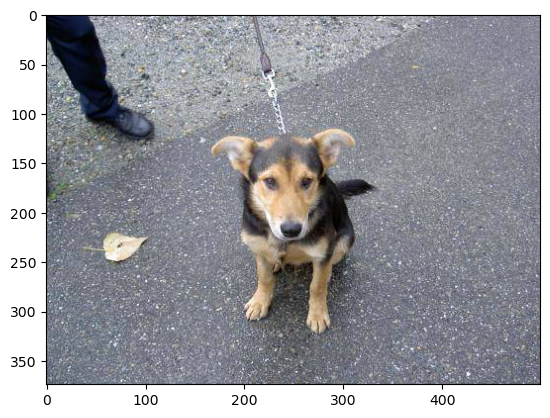

In [20]:
sample = random.choice(filenames)
image = load_img("cats_vs_dogs/train/" + sample)
plt.imshow(image)


In [21]:
df["class"] = df["class"].replace({0: 'cat', 1: 'dog'}) 
df.head()

,filename,class
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [22]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=7)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [23]:
train_df.head()

,filename,class
0,cat.1676.jpg,cat
1,dog.4408.jpg,dog
2,cat.2768.jpg,cat
3,dog.4840.jpg,dog
4,cat.4622.jpg,cat


In [24]:
validate_df.head()

,filename,class
0,dog.7075.jpg,dog
1,cat.5235.jpg,cat
2,dog.2850.jpg,dog
3,dog.6177.jpg,dog
4,dog.7753.jpg,dog


In [33]:
# Define our images sizes
IMAGE_WIDTH = 150
IMAGE_HEIGHT = 150
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [34]:
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "cats_vs_dogs/train/", 
    x_col = 'filename',
    y_col = 'class',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [36]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "cats_vs_dogs/train/", 
    x_col='filename',
    y_col='class',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [32]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 1)                 2049      
                                                           

In [38]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/20
625/625 [==============================] - 933s 1s/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 2/20
625/625 [==============================] - 913s 1s/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 3/20
625/625 [==============================] - 878s 1s/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 4/20
625/625 [==============================] - 881s 1s/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 5/20
625/625 [==============================] - 890s 1s/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 6/20
625/625 [==============================] - 892s 1s/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 7/20
625/625 [==============================] - 885s

: 